In [243]:
from collections import defaultdict
import re
import random
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx
from zfnetwork import grn, ssa

In [34]:
with open('../data/cis-reg/node_types.txt') as input:
    node_types = {line.split()[0]: line.split()[1] for line in input}

with open('../data/cis-reg/final_edge_list.txt') as input:
    edges = [tuple(line.strip().split('\t')) for line in input]

znf_grn = grn.ZincFingerGRN()
znf_grn.from_edge_list(edges, node_types)
print(f'# Nodes = {len(node_types)}')
print(f'# Edges = {len(edges)}')

# Nodes = 1398
# Edges = 13477


In [35]:
zf_edges = defaultdict(list)
zf_targets = set()
for p1, p2 in znf_grn._extract_zf_edges():
    zf_edges[p1].append((p1, p2))

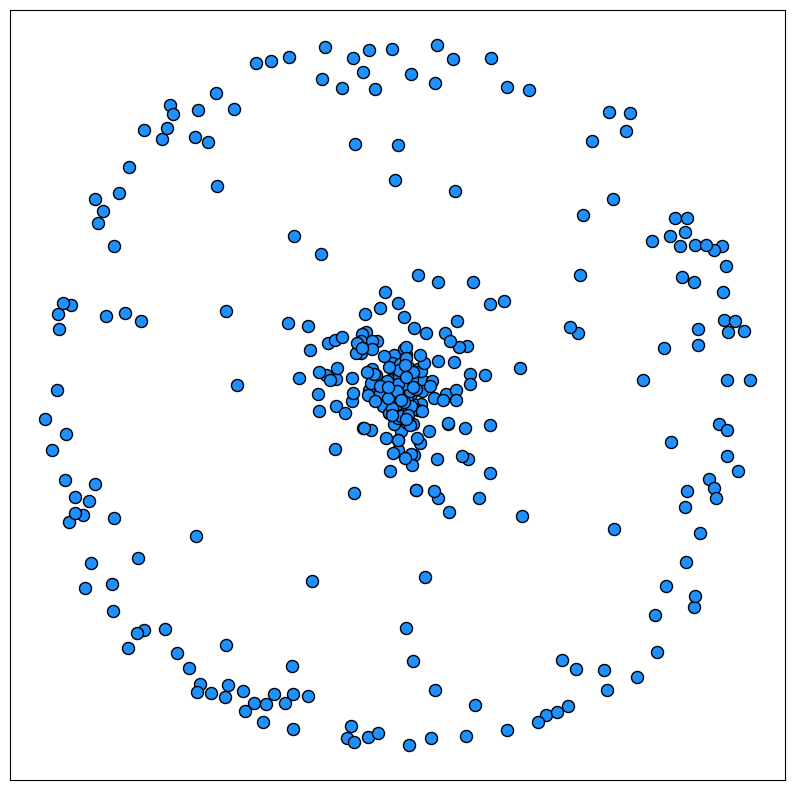

In [392]:
G = znf_grn.to_digraph()
layout = nx.spring_layout(G)
tf_nodes = [node.label for node in znf_grn.tfs]
zf_nodes = [node.label for node in znf_grn.zfs]
te_nodes = [node.label for node in znf_grn.tes]

node_types = {}
for tf in tf_nodes:
    node_types[tf] = 'TF'
for zf in zf_nodes:
    node_types[zf] = 'ZF'
for te in te_nodes:
    node_types[te] = 'TE'

tf_to_znf93 = []
for i, j in G.edges:
    if j == 'ZNF93' and i in tf_nodes:
        tf_to_znf93.append((i, j))

plt.figure(figsize=(10, 10))
# nx.draw_networkx_nodes(G, nodelist=te_nodes, pos=layout, node_color='grey',
#                        edgecolors='black', node_size=75)
nx.draw_networkx_nodes(G, nodelist=zf_nodes, pos=layout, node_color='dodgerblue',
                       edgecolors='black', node_size=75)
# nx.draw_networkx_nodes(G, nodelist=tf_nodes, pos=layout, node_color='orange',
#                        edgecolors='black', node_size=75)
# nx.draw_networkx_nodes(G, nodelist=['ZNF93'], pos=layout, node_color='skyblue',
#                        edgecolors='black', node_size=250, label=True)

# nx.draw_networkx_edges(G, edgelist=zf_edges['ZNF93'], pos=layout, edge_color='red')
# nx.draw_networkx_edges(G, edgelist=tf_to_znf93, pos=layout, edge_color='grey')

# plt.savefig('/Users/jonwells/Desktop/znf_grn.pdf')
plt.show()

# Network analysis
Having loaded our gene regulatory network (GRN), we would like to analyse its properties.

1. What is the degree distribution of ZFs
2. Is the number of cycles greater than expected by chance?
3. Correlation between connectivity
    

### Degree distribution of ZFPs
Looking at the number of genes or TEs regulated by ZFPs, we see that there is a fat tailed distribution

In [254]:
zf_degree = []
for zf in znf_grn.zfs:
    targets = [edge.y.output[0].y.label for edge in zf.output]
    te_targets = [node for node in targets if node in te_nodes]
    zf_targets = [node for node in targets if node in zf_nodes]
    tf_sources = [edge.x.label for edge in zf.input if edge.x.label in tf_nodes]
    zf_degree.append((zf.label, 'ZF', len(te_targets), len(zf_targets), len(tf_sources)))

te_degree = []
for te in znf_grn.tes:
    tf_sources = [edge.x.label for edge in te.input if edge.x.label in tf_nodes]
    te_degree.append((te.label, 'TE', np.nan, np.nan, len(tf_sources)))


degree_dist_df = pd.DataFrame(zf_degree + te_degree, columns=['node_name', 'node_type', 'te_out', 'zf_out', 'tf_in'])
degree_dist_df

,node_name,node_type,te_out,zf_out,tf_in
0,ZNF182,ZF,36.0,142.0,18
1,ZNF200,ZF,0.0,0.0,33
2,ZNF266,ZF,7.0,1.0,10
3,ZNF547,ZF,7.0,6.0,14
4,ZNF559-ZNF177,ZF,0.0,0.0,32
...,...,...,...,...,...
927,LTR15,TE,NaN,NaN,0
928,L1M,TE,NaN,NaN,0
929,L1P,TE,NaN,NaN,0
930,EUTREP8,TE,NaN,NaN,0


/Users/jonwells/miniconda3/envs/grn_env/lib/python3.12/site-packages/matplotlib/text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/jonwells/miniconda3/envs/grn_env/lib/python3.12/site-packages/matplotlib/text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))


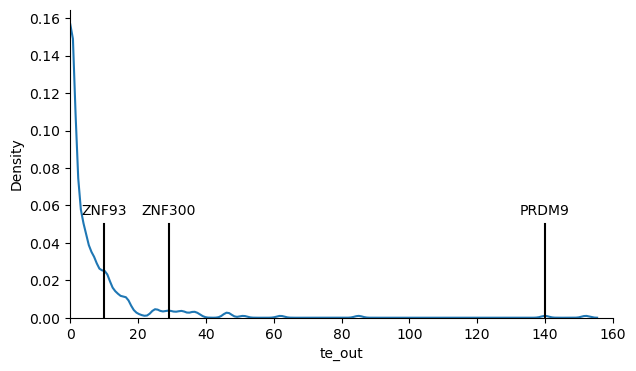

In [255]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.set_xlim(0, 160)
sns.kdeplot(degree_dist_df.te_out, bw_adjust=0.25, clip=(0, 500), ax=ax)
for zf in ['ZNF93', 'PRDM9', 'ZNF300']:
    ax.plot((degree_dist_df.loc[degree_dist_df.node_name ==  zf, 'te_out'], degree_dist_df.loc[degree_dist_df.node_name ==  zf, 'te_out']), (0, 0.05), color='k')
    ax.text(degree_dist_df.loc[degree_dist_df.node_name ==  zf, 'te_out'], 0.055, zf, ha='center')
sns.despine()
plt.savefig('/Users/jonwells/Desktop/znf_grn_degree_distribution.jpg', dpi=300)
plt.show()

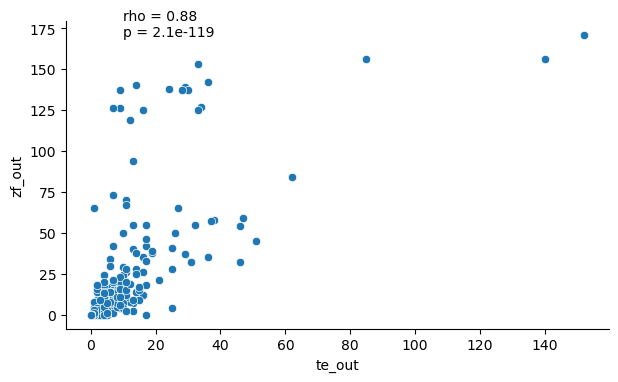

In [259]:
r, p = stats.spearmanr(degree_dist_df.te_out, degree_dist_df.zf_out, nan_policy='omit')

fig, ax = plt.subplots(figsize=(7, 4))
sns.scatterplot(degree_dist_df, x='te_out', y='zf_out')
ax.text(10, 170, f'rho = {r:.2f}\np = {p:.1e}')
sns.despine()
plt.savefig('/Users/jonwells/Desktop/te_zf_degree_distribution.jpg', dpi=300)
plt.show()


In [274]:
counts_dict = {}
with open('../data/cis-reg/ipsc-expression/TEcount-out/ERR947017.cntTable') as infile:
    infile.readline()
    for line in infile:
        line = line.strip().split()
        line[0] = line[0].strip('"')
        if re.match('gene-(.+)', line[0]):
            name = re.match('gene-(.+)', line[0]).group(1)
        else:
            name = line[0].split(':')[0]
        count = int(line[1])
        counts_dict[name] = count

degree_dist_df['counts'] = degree_dist_df['node_name'].apply(counts_dict.get)
degree_dist_df['counts'] += 1
degree_dist_df['parent_TF'] = False
degree_dist_df.loc[degree_dist_df.tf_in != 0, 'parent_TF'] = True
degree_dist_df

,node_name,node_type,te_out,zf_out,tf_in,counts,parent_TF
0,ZNF182,ZF,36.0,142.0,18,373.0,True
1,ZNF200,ZF,0.0,0.0,33,147.0,True
2,ZNF266,ZF,7.0,1.0,10,424.0,True
3,ZNF547,ZF,7.0,6.0,14,34.0,True
4,ZNF559-ZNF177,ZF,0.0,0.0,32,43.0,True
...,...,...,...,...,...,...,...
927,LTR15,TE,NaN,NaN,0,33.0,False
928,L1M,TE,NaN,NaN,0,15.0,False
929,L1P,TE,NaN,NaN,0,2.0,False
930,EUTREP8,TE,NaN,NaN,0,4.0,False


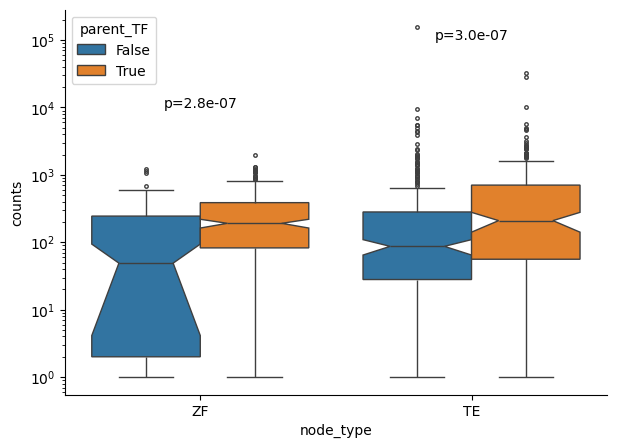

In [311]:
zf_pval = stats.ranksums(degree_dist_df.loc[(degree_dist_df.node_type == 'ZF') & (degree_dist_df.parent_TF == True), 'counts'],
                         degree_dist_df.loc[(degree_dist_df.node_type == 'ZF') & (degree_dist_df.parent_TF == False), 'counts'],
                         nan_policy='omit')[1]
te_pval = stats.ranksums(degree_dist_df.loc[(degree_dist_df.node_type == 'TE') & (degree_dist_df.parent_TF == True), 'counts'],
                         degree_dist_df.loc[(degree_dist_df.node_type == 'TE') & (degree_dist_df.parent_TF == False), 'counts'],
                         nan_policy='omit')[1]

fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=degree_dist_df, x='node_type', y='counts', hue='parent_TF', notch=True, fliersize=2.5)
# sns.stripplot(data=degree_dist_df, x='node_type', y='counts', hue='parent_TF', dodge=True, edgecolor='k', linewidth=1, alpha = 0.5, jitter=0.25)
ax.text(0, 1e4, f'p={zf_pval:.1e}', ha='center')
ax.text(1, 1e5, f'p={te_pval:.1e}', ha='center')
ax.set_yscale('log')
sns.despine()
plt.savefig('/Users/jonwells/Desktop/parent_tf.jpg')
plt.show()

## Analysis of network motifs
Is the number of cycles greater than expected by chance?

In [332]:
zf_edges = defaultdict(list)
zf_target_list = []
for p1, p2 in znf_grn._extract_zf_edges():
    zf_edges[p1].append(p2)
    zf_target_list.append(p2)

network_samples = []
nsamples = 1000
for sample in range(nsamples):
    idx = 0
    current_sample = []
    random.shuffle(zf_target_list)
    for zf, targets in zf_edges.items():
        zf_targets = [node for node in targets if node in zf_nodes]
        current_sample += [(zf, node) for node in targets if node not in zf_nodes]
        for i in zf_targets:
            current_sample.append((zf, zf_target_list[idx]))
            idx += 1
    random_graph = nx.DiGraph()
    random_graph.add_edges_from(current_sample)
    random_graph.remove_nodes_from(te_nodes)
    network_samples.append(random_graph)

In [350]:
ZF_G = G.copy()
ZF_G.remove_nodes_from(te_nodes)
ZF_G.remove_nodes_from(tf_nodes)

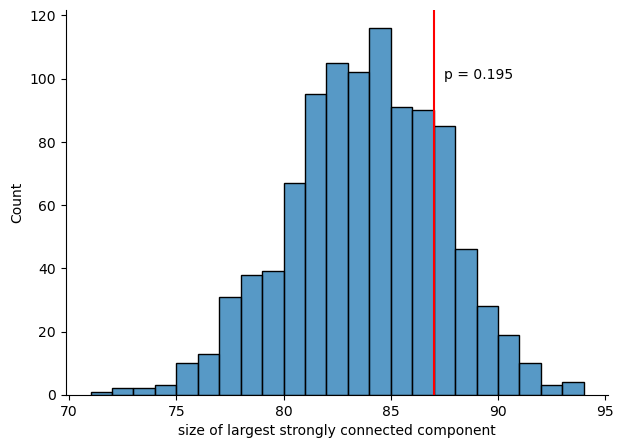

In [391]:
observed = sorted(nx.strongly_connected_components(ZF_G), key=len)
control = [sorted((nx.strongly_connected_components(x)), key=len) for x in network_samples]
control_dist = [len(c[-1]) for c in control]

success = 0
for x in control_dist:
    if x >= len(observed[-1]):
        success += 1
p = success/len(control_dist)

fig, ax = plt.subplots(figsize=(7, 5))
plt.axvline(len(observed[-1]), color='r')
sns.histplot([len(c[-1]) for c in control], ax=ax, binwidth=1)
ax.set_xlabel('size of largest strongly connected component')
ax.text(87.5, 100, f'p = {p}')
sns.despine()

plt.show()

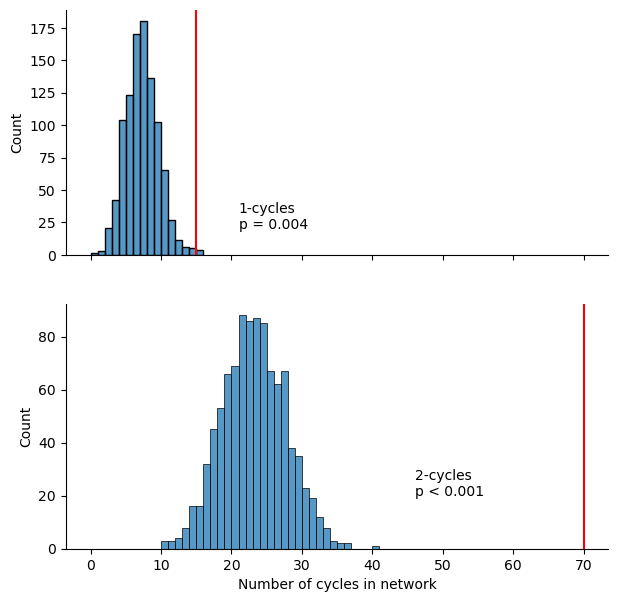

In [402]:
fig, axes = plt.subplots(figsize=(7, 7), nrows=2, sharex=True)
for i, cycle_len in enumerate([1, 2]):
    
    observedcycles = [i for i in list(nx.simple_cycles(ZF_G, length_bound=cycle_len)) if len(i) == cycle_len]
    
    rcycle_dist = []
    for ns in network_samples:
        randomcycles = [i for i in list(nx.simple_cycles(ns, length_bound=cycle_len)) if len(i) == cycle_len]
        rcycle_dist.append(len(randomcycles))

    s = 0
    n = len(rcycle_dist)
    for x in rcycle_dist:
        if x >= len(observedcycles):
            s += 1
    p = s/n
    if p == 0:
        axes[i].text(max(rcycle_dist)+5, 20, f'{cycle_len}-cycles\np < {1/n}')
    else:
        axes[i].text(max(rcycle_dist)+5, 20, f'{cycle_len}-cycles\np = {p}')
    axes[i].axvline(len(observedcycles), color='r')
    sns.histplot(rcycle_dist, ax=axes[i], binwidth=1)
    
axes[1].set_xlabel('Number of cycles in network')  
sns.despine()
plt.show()

## Modelling the expected behavior of KZFP networks

['ZBTB33', 'ZFP42', 'Thap11', 'KLF4']

['MLT1A', 'MLT1J2', 'Charlie3', 'MER21-int', 'LTR1D1', 'HAL1b', 'LTR1E', 'MER21C', 'LTR12D', 'LTR1F1', 'L1PB1', 'MER61-int', 'LTR1F2', 'MER1B', 'L1PA6', 'L1PA8', 'L1PA8A', 'L1PA7', 'LTR8A', 'LTR7Y', 'MER57-int', 'LTR12C', 'MLT1O', 'LTR67B', 'LTR1B1', 'LTR33A', 'LTR1B0', 'MER21A', 'MLT1J1', 'MLT1J', 'LTR1F', 'MER41-int', 'LTR2752', 'L1MC3', 'L1M2a1', 'MER52D', 'LTR1B', 'LTR33B', 'HERV1_LTRe', 'LTR12E']

['ZNF736', 'ZNF496', 'ZNF695', 'ZNF850', 'ZNF549', 'ZNF680', 'ZNF8', 'ZNF605', 'ZNF333', 'ZNF445', 'RBAK', 'ZNF836', 'ZNF302', 'ZNF621', 'ZNF616', 'ZNF133', 'ZNF417', 'ZNF763', 'ZNF2', 'ZNF182', 'ZNF566', 'ZNF561', 'ZNF211', 'ZNF506', 'ZNF354C', 'ZNF789', 'ZNF429', 'ZNF17', 'ZNF641', 'ZNF33B', 'ZNF440', 'ZNF765', 'ZNF324', 'ZNF626', 'ZNF382', 'ZNF160', 'ZNF879', 'ZNF251', 'ZNF558', 'ZNF10', 'ZNF615', 'ZNF891', 'ZNF354A', 'ZNF587', 'ZNF347', 'ZNF43', 'ZNF317', 'ZNF677', 'ZNF273', 'ZNF480', 'ZNF649', 'ZNF205']


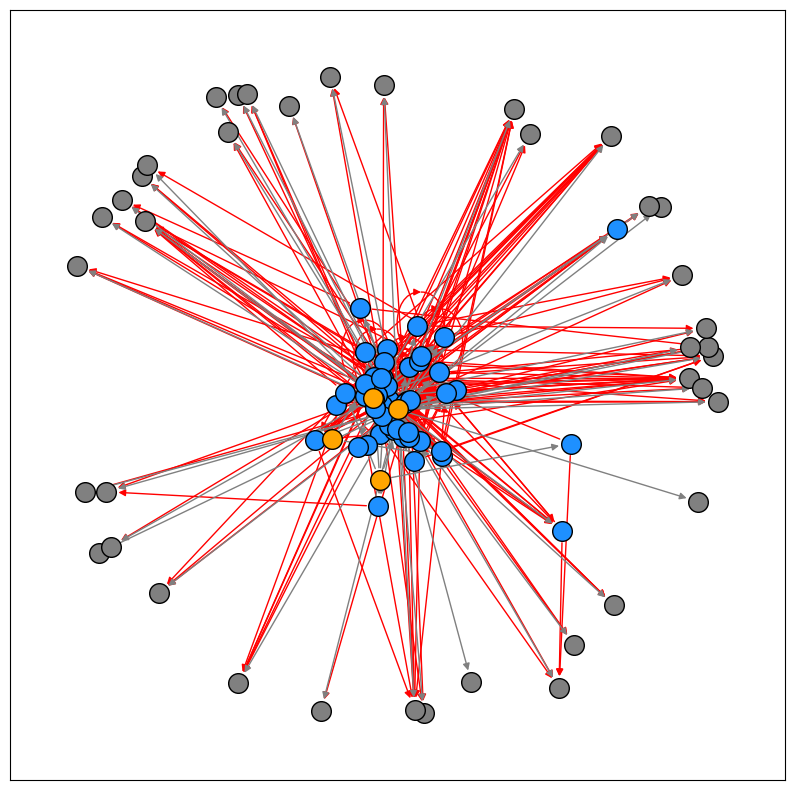

In [161]:
np.random.seed(113731)

test_tf_nodes = list(np.random.choice(tf_nodes, 4, replace=False))
test_te_nodes = list(set([edge.y.label for edge in znf_grn.edges if edge.y.label in te_nodes and edge.x.label in test_tf_nodes]) )
test_zf_nodes1 = set(i for (i, j) in G.edges if i in zf_nodes and j in test_te_nodes)
test_zf_nodes2 = set(j for (i, j) in G.edges if j in zf_nodes and i in test_tf_nodes)
test_zf_nodes = list(test_zf_nodes1.intersection(test_zf_nodes2))
print(test_tf_nodes)
print()
print(test_te_nodes)
print()
print(test_zf_nodes)

test_nodes = test_tf_nodes + test_zf_nodes + test_te_nodes
test_edges = [(i, j) for i, j in G.edges if i in test_nodes and j in test_nodes]

test_grn = grn.ZincFingerGRN()
test_grn.from_edge_list(test_edges, node_types)

T = test_grn.to_digraph()
layout = nx.spring_layout(G)
test_tf_nodes = [node.label for node in test_grn.tfs]
test_zf_nodes = [node.label for node in test_grn.zfs]
test_te_nodes = [node.label for node in test_grn.tes]


plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(T, nodelist=test_te_nodes, pos=layout, node_color='grey',
                       edgecolors='black', node_size=200)
nx.draw_networkx_nodes(T, nodelist=test_zf_nodes, pos=layout, node_color='dodgerblue',
                       edgecolors='black', node_size=200)
nx.draw_networkx_nodes(T, nodelist=test_tf_nodes, pos=layout, node_color='orange',
                       edgecolors='black', node_size=200)
nx.draw_networkx_edges(T, edgelist=[e for e in T.edges if e[0] in test_zf_nodes], edge_color='red', pos=layout)
nx.draw_networkx_edges(T, edgelist=[e for e in T.edges if e[0] not in test_zf_nodes], edge_color='grey', pos=layout)
plt.show()

rep: 0
rep: 5
rep: 10
rep: 15
rep: 20
rep: 25
rep: 30
rep: 35
rep: 40
rep: 45


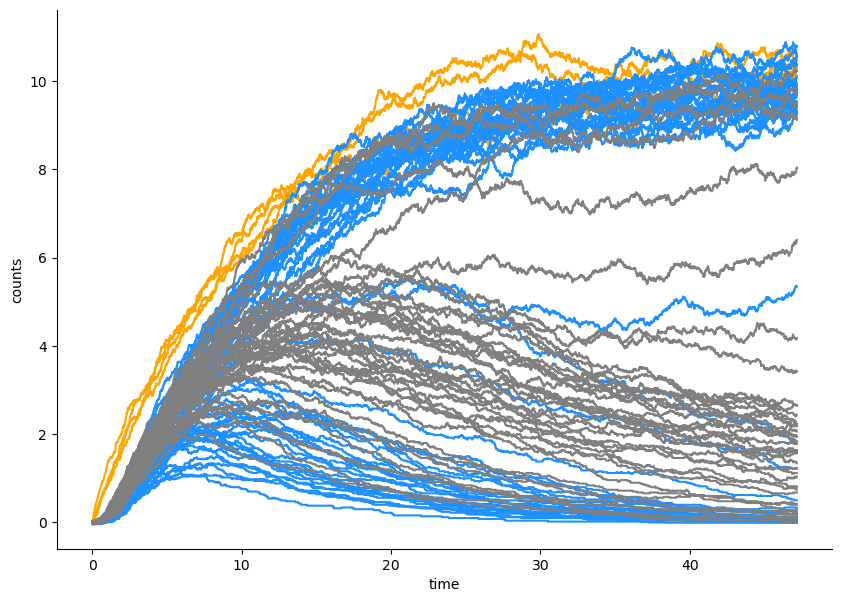

In [162]:
tlog, plog = ssa.gillespie_ssa(test_grn, 5000, 50)
ssa.plot_data(tlog, plog, test_grn)